# アドバンスドビジョンレポート
## Cannyエッジ検出の実装

本レポートでは、OpenCVの画像処理ライブラリを使用せずにゼロから実装するものである。
### ライブラリの読み込み

In [1]:
%matplotlib inline
import time
import copy
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import image as m_img

### 写真の読み込みと表示

image shape: (540, 960, 3)


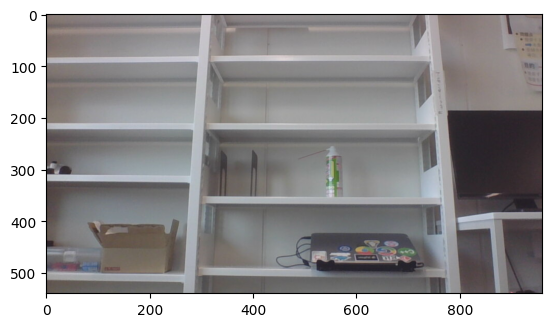

In [2]:
image = m_img.imread('background.jpg')

plt.imshow(image)
print('image shape:', image.shape)

### RGB画像をグレースケール化

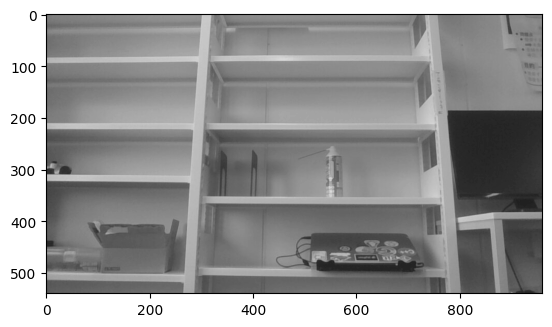

In [3]:
img_height, img_width, _ = image.shape
gray_image = np.zeros((img_height, img_width))

red_image = image[:,:,0]
green_image = image[:,:,1]
blue_image = image[:,:,2]

gray_image = (red_image*0.299) + (green_image*0.587) + (blue_image*0.114)

plt.imshow(gray_image, cmap='gray', vmin=0.0, vmax=255.0)

### 5x5ガウシアンフィルタで写真のノイズを除去

In [4]:
def generate_gaussian_kernel(size, sigma):
    # カーネルのサイズは必ず奇数である
    assert size % 2 != 0, f"Expected kernel size to be odd number、got: {size}"
    
    # floor計算: 5//2 == 2
    kernel_center = size//2
    
    # 行列のそれぞれの位置座標から中心点までの距離の行列
    # 列: 5x5の行列で、0行2列の要素から中心点3,3までの移動距離は
    #    それぞれ|0-3|,|2-3| -> sqrt(3**2 + 1**2)である
    #    この距離に応じてガウス分布の分布があれば、その点の重み(確率密度)
    #    を計算する事が出来る
    # mgridを使用すると、簡単にそれぞれ要素に当てはまる位置座標の行列を
    # 簡単に作成出来る
    distance_row, distance_col = np.mgrid[-kernel_center:kernel_center+1,
                                          -kernel_center:kernel_center+1]
    
    return (1/(2.0*np.pi*sigma**2)) * (np.exp(-(distance_row**2 + distance_col**2)/(2*sigma**2)))

In [5]:
# 手動で作るガウシアンフィルタは行列のそれぞれの
# 要素に好きな値を調整する事が可能で、
# ガウス分布のσ値をピッタリ中心点と行列の一番外に
# あるの要素の間にある要素に、相当する値を簡単に
# 代入出来る。
# 
# 自動生成はそれぞれの要素に自動で値を入れられるが、
# 行列の端にある要素にガウス分布の端の値が代入され
# るとは限らない。なぜなら、要素の間にある物理距離は
# 分布の値に直接反映されるからだ。

# 中心: 5x5の標準偏差σ=10.3のガウシアンフィルタ
gaussian_filter = (np.array([[1,4,7,4,1],
                           [4,16,26,16,4],
                           [7,26,41,26,7],
                           [4,16,26,16,4],
                           [1,4,7,4,1]]))/273

# サイズ5x5、σ=1.0のガウシアンフィルタを生成する
gaussian_filter = generate_gaussian_kernel(5, 1)

print(gaussian_filter)

[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


hand made for loop 2D convolution time: 1.4737341403961182
built-in 2D convolution time: 0.03615617752075195


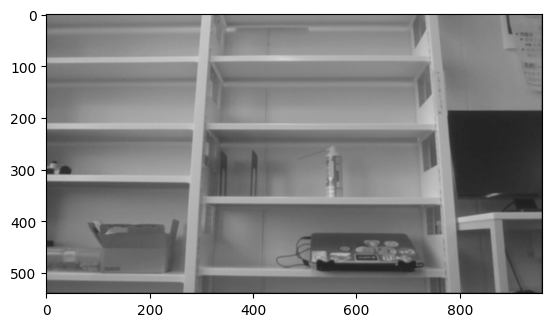

In [6]:
smooth_gray_image = np.zeros(gray_image.shape)

# for loop 2D convolution
start = time.time()
for h in range(2, img_height-2):
    for w in range(2, img_width-2):
        smooth_gray_image[h, w] = (gray_image[h-2:h+3, w-2:w+3] * gaussian_filter).sum()
for_loop_time = time.time() - start

# scipy.signal function 2D convolution
start = time.time()
smooth_gray_image = signal.convolve2d(gray_image, gaussian_filter, mode="same", boundary="fill", fillvalue=0)
builtin_time = time.time() - start

print("hand made for loop 2D convolution time:", for_loop_time)
print("built-in 2D convolution time:", builtin_time)

plt.imshow(smooth_gray_image, cmap='gray', vmin=0.0, vmax=255.0)

### Sobelフィルターで画像の縦と横軸をそれぞれ1次微分を行い、画像の輝度の勾配を計算する

In [18]:
sobel_col = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
sobel_row = np.array([[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]])

image_gradient_intensity0 = np.zeros(smooth_gray_image.shape)
image_gradient_angle0 = np.zeros(smooth_gray_image.shape)

# hand made for loop sobel
start = time.time()
for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        gradient_col = (smooth_gray_image[row-1:row+2, col-1:col+2] * sobel_col).sum()
        gradient_row = (smooth_gray_image[row-1:row+2, col-1:col+2] * sobel_row).sum()
        
        image_gradient_intensity0[row, col] = np.sqrt(gradient_row**2 + gradient_col**2)
        image_gradient_angle0[row, col] = np.arctan2(gradient_row, gradient_col)
for_loop_time = time.time() - start

In [26]:
# scipy signal 2D convolution sobel
# なお、signal.convolution2dはカーネルをひっくり返して畳み込む
# ため、エッジの角度と濃淡は順方向とは違う値が帰ってくる。
# この問題を解決するために、np.fliplr, np.flipudで解決できる
# ちなみに、signal.correlate2d(img, kernel)を使用すると、
# ひっくり返す必要がなくなる
start = time.time()

gradient_col = signal.convolve2d(gray_image, sobel_col, mode="same", boundary="fill", fillvalue=0)
gradient_row = signal.convolve2d(gray_image, sobel_row, mode="same", boundary="fill", fillvalue=0)

image_gradient_intensity1 = np.hypot(gradient_row, gradient_col)
image_gradient_angle1 = np.arctan2(gradient_row, gradient_col)

builtin_time1 = time.time() - start

In [27]:
# scipy signal 2D convolution flipped sobel
start = time.time()

gradient_col = signal.convolve2d(gray_image, np.flipud(np.fliplr(sobel_col)), mode="same", boundary="fill", fillvalue=0)
gradient_row = signal.convolve2d(gray_image, np.fliplr(np.flipud(sobel_row)), mode="same", boundary="fill", fillvalue=0)

image_gradient_intensity2 = np.hypot(gradient_row, gradient_col)
image_gradient_angle2 = np.arctan2(gradient_row, gradient_col)

builtin_time2 = time.time() - start

In [28]:
# scipy signal 2D correlation sobel
start = time.time()

gradient_col = signal.correlate2d(gray_image, sobel_col, mode="same", boundary="fill", fillvalue=0)
gradient_row = signal.correlate2d(gray_image, sobel_row, mode="same", boundary="fill", fillvalue=0)

image_gradient_intensity3 = np.hypot(gradient_row, gradient_col)
image_gradient_angle3 = np.arctan2(gradient_row, gradient_col)

builtin_time3 = time.time() - start

hand made for loop 2D convolution time: 4.700994491577148
built-in 2D convolution time: 0.06632828712463379
built-in 2D flipped convolution time: 0.0773615837097168
built-in 2D correlation time: 0.06357669830322266


hand made intensity 2.2221513111533393
convolution 2D intensity 3.0883225220173958
flipped convolution 2D intensity 3.0883225220173958
correlation 2D intensity 3.0883225220174007


hand made angle 0.4313890635798449
convolution 2D angle -2.476459992598633
flipped convolution 2D angle -2.476459992598633
correlation 2D angle 0.6651326609911477


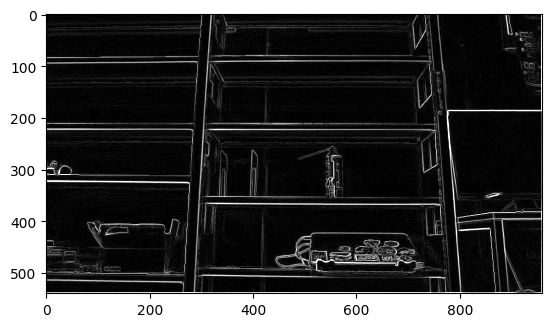

In [36]:
# 勾配の値をスケールする、大きな値がより大きくする
gradient_scale = 2
image_gradient_intensity *= gradient_scale
        
# 255を超えた値を255にする
image_gradient_intensity[(image_gradient_intensity > 255)] = 255

print("hand made for loop 2D convolution time:", for_loop_time)
print("built-in 2D convolution time:", builtin_time1)
print("built-in 2D flipped convolution time:", builtin_time2)
print("built-in 2D correlation time:", builtin_time3)
print("\n")
print("hand made intensity", image_gradient_intensity0[200,100])
print("convolution 2D intensity", image_gradient_intensity1[200,100])
print("flipped convolution 2D intensity", image_gradient_intensity2[200,100])
print("correlation 2D intensity", image_gradient_intensity3[200,100])
print("\n")
print("hand made angle", image_gradient_angle0[200,100])
print("convolution 2D angle", image_gradient_angle1[200,100])
print("flipped convolution 2D angle", image_gradient_angle[200,100])
print("correlation 2D angle", image_gradient_angle3[200,100])

plt.imshow(image_gradient_intensity3, cmap='gray', vmin=0.0, vmax=255.0)

### 非極大値の抑制

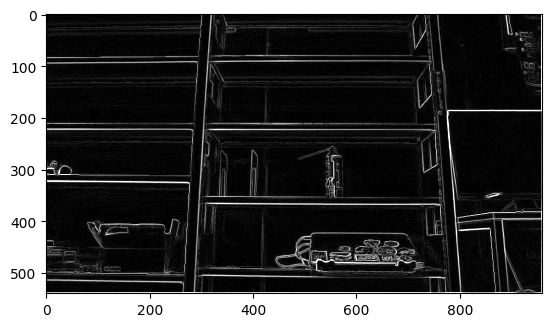

In [37]:
for row in range(1, img_height-1):
    for col in range(1, img_width-1):
        # 縦エッジ
        if (abs(image_gradient_angle3[row, col]) <= np.radians(22.5)):
            if (image_gradient_intensity3[row, col] < image_gradient_intensity3[row, col-1])\
                or (image_gradient_intensity3[row, col] < image_gradient_intensity3[row, col+1]):
                image_gradient_intensity3[row, col] = 0.0
        # 横エッジ
        elif np.radians(67.5) < image_gradient_angle3[row, col] <= np.radians(112.5):
            if (image_gradient_intensity[row, col] < image_gradient_intensity3[row-1, col])\
                or (image_gradient_intensity3[row, col] < image_gradient_intensity3[row+1, col]):
                image_gradient_intensity3[row, col] = 0.0
        # 右斜め上と左斜め下エッジ
        elif (np.radians(22.5) < image_gradient_angle3[row, col] <= np.radians(67.5)):
            if (image_gradient_intensity[row, col] < image_gradient_intensity3[row-1, col-1])\
                or (image_gradient_intensity3[row, col] < image_gradient_intensity3[row+1, col+1]):
                image_gradient_intensity3[row, col] = 0.0            
        # 右斜め下と左斜め上エッジ
        elif (np.radians(112.5) < image_gradient_angle[row, col] <= np.radians(157.5)):            
            if (image_gradient_intensity[row, col] < image_gradient_intensity3[row-1, col+1])\
                or (image_gradient_intensity3[row, col] < image_gradient_intensity3[row+1, col-1]):
                image_gradient_intensity3[row, col] = 0.0

#plt.imsave('non-maxima-supp.jpg', image_gradient_intensity)
plt.imshow(image_gradient_intensity3, cmap='gray', vmin=0.0, vmax=255.0)

### ヒステリシスしきい値処理

In [41]:
low_threshold = 50.0
high_threshold = 100.0

weak_edge = 200.0
strong_edge = 255.0

l_image = np.zeros(image_gradient_intensity3.shape)
h_image = np.zeros(image_gradient_intensity3.shape)
hys_image = np.zeros(image_gradient_intensity3.shape)

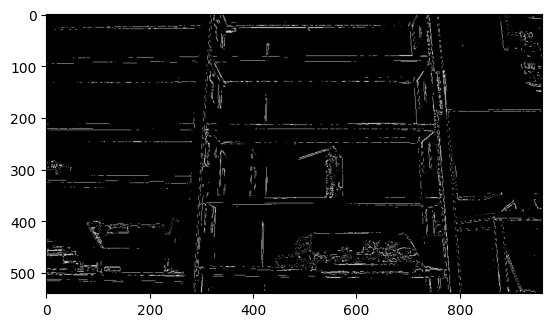

In [42]:
# 弱いエッジの画像
mask = (image_gradient_intensity3 > low_threshold) & (image_gradient_intensity3 < high_threshold)
l_image += (weak_edge * mask)

#plt.imsave('low-hysterasis.jpg', l_image)
plt.imshow(l_image, cmap='gray', vmin=0.0, vmax=255.0)

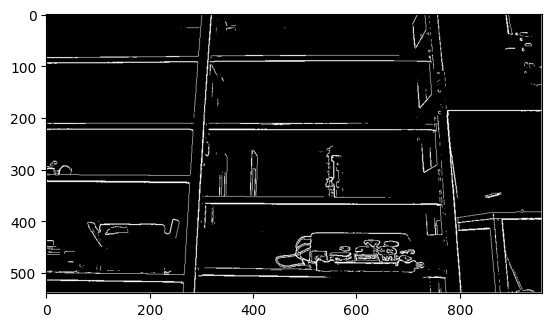

In [43]:
# 強いエッジの画像
mask = (image_gradient_intensity3 > high_threshold)
h_image += (strong_edge * mask)

#plt.imsave('high-hysterasis.jpg', h_image)
plt.imshow(h_image, cmap='gray', vmin=0.0, vmax=255.0)

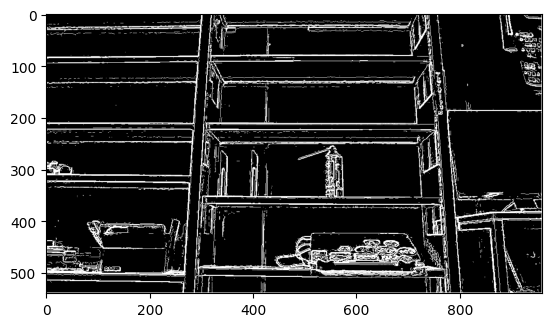

In [11]:
# ヒステリシスしきい値処理
# 強いエッジと繋がっている弱いエッジを強いエッジに変換する

# 弱いエッジと強いエッジの合体画像
hys_image = l_image + h_image

plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

In [24]:
# 強いエッジと繋がっている画素を探し、追加する
old_strong_edges = hys_image
new_strong_edges = np.array([0])

# 強いエッジの周りにある弱いエッジを強いエッジにするために、
# 畳み込み行列で変換を行う
weak_to_strong = np.array([[1/weak_edge, 1/weak_edge, 1/weak_edge],
                           [1/weak_edge, 1/strong_edge, 1/weak_edge],
                           [1/weak_edge, 1/weak_edge, 1/weak_edge]])

# 強いエッジと繋がる弱いエッジを全部探すループ
while(not (old_strong_edges == new_strong_edges).all()):
    pass
    new_strong_edges = signal.convolve2d(old_strong_edges, weak_to_strong, mode="same", boundary="fill", fillvalue=0)

KeyboardInterrupt: 

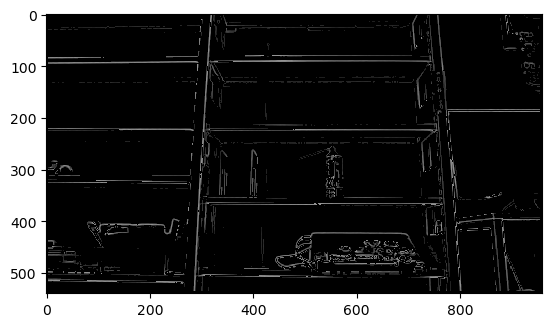

In [14]:
# ヒステリシスしきい値処理
for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        if low_threshold < image_gradient_intensity[row, col] < high_threshold:
            hys_image[row, col] = image_gradient_intensity[row, col]

#plt.imsave('hysterasis.jpg', hys_image)
plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

### OpenCVライブラリを用いたCannyエッジ検出との比較

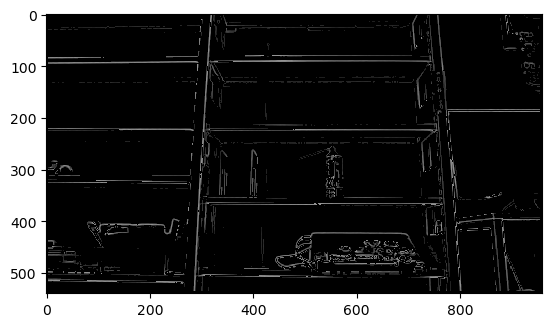

In [15]:
# 本レポートで実装したCannyエッジ検出画像            
plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

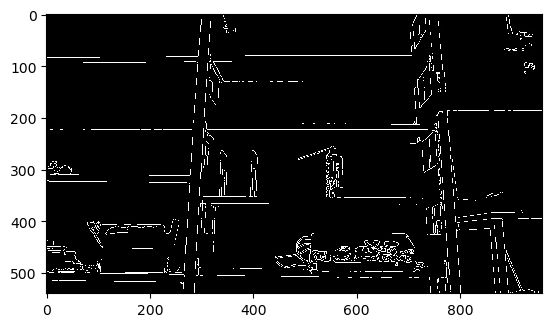

In [16]:
# OpenCVのCannyエッジ検出画像
opencv_image = m_img.imread('opencv_canny_edge.jpg')
plt.imshow(opencv_image, cmap='gray', vmin=0.0, vmax=255.0)